<a href="https://colab.research.google.com/github/Punitpawar5/Plant-Disease-Prediction/blob/main/Plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant Disease Detection Using Deep Learning
###Project Description
This project focuses on building a Convolutional Neural Network (CNN) to automatically detect plant leaf diseases from images. The goal is to classify images of healthy and diseased leaves across multiple plant types using the PlantVillage dataset.

It leverages image classification techniques in deep learning to help farmers and agricultural researchers identify diseases early, which can improve crop management and yield.

##Importing dataset directly from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"punitpawar","key":"59e824c52c9ebf9460dad1b2b64c0f2e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [3]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 90% 589M/658M [00:11<00:02, 33.7MB/s]
100% 658M/658M [00:11<00:00, 62.2MB/s]


In [4]:
!unzip -q plantdisease.zip -d plant_disease

In [9]:
!ls plant_disease/

plantvillage  PlantVillage


In [10]:
import os

base_dir = 'plant_disease'
categories = os.listdir(base_dir)
print("Categories:", categories)

for cat in categories:
    path = os.path.join(base_dir, cat)
    count = sum([len(files) for _,_,files in os.walk(path)])
    print(f"{cat}: {count} images")


Categories: ['PlantVillage', 'plantvillage']
PlantVillage: 20639 images
plantvillage: 20639 images


##Data splitting into Training and Testing


In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Source path (your original dataset). Adjusted to point to the directory containing class folders.
# Based on the error path 'plant_disease/plantvillage/PlantVillage/...',
# the source of the actual class directories seems to be 'plant_disease/plantvillage/PlantVillage'
source_dir = "plant_disease/plantvillage/PlantVillage"

# Destination paths
train_dir = "plant_disease/train"
test_dir = "plant_disease/test"

# Create destination folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder (these are now the actual class directories like 'Pepper__bell___healthy')
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # Ensure the item is a directory (an actual class folder)
    if not os.path.isdir(class_path):
        continue  # Skip any files that might be directly in source_dir

    # Now list the images within the class folder
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))] # Filter to only list files

    # Skip if there are no images in the folder
    if not images:
        print(f"Warning: No images found in {class_path}. Skipping.")
        continue

    # Split the list of images
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create class folders in train and test dirs
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy training images
    for img in train_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy2(src, dst)

    # Copy testing images
    for img in test_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy2(src, dst)

print(" Dataset successfully split into 80% train and 20% test.")

 Dataset successfully split into 80% train and 20% test.


##Model Building

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Image data generator with basic preprocessing (rescaling)
datagen = ImageDataGenerator(rescale=1./255)

# 2. Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),   # FER2013 images are 48x48
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

# 3. Load testing data
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

Found 16504 images belonging to 16 classes.
Found 4134 images belonging to 16 classes.


In [17]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_data, validation_data=test_data, epochs=30, callbacks=[early_stop])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.2309 - loss: 2.3735 - val_accuracy: 0.6118 - val_loss: 1.3782
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.4973 - loss: 1.5097 - val_accuracy: 0.7199 - val_loss: 0.9599
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5615 - loss: 1.2934 - val_accuracy: 0.6853 - val_loss: 0.9626
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.5804 - loss: 1.2087 - val_accuracy: 0.7392 - val_loss: 0.8237
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.6151 - loss: 1.1082 - val_accuracy: 0.7644 - val_loss: 0.7305
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.6240 - loss: 1.1018 - val_accuracy: 0.7687 - val_loss: 0.7256
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.6512 - loss: 1.0108 - val_accuracy: 0.7709 - val_loss: 0.7337
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.6606 - loss: 0.9751 - val_accurac

##Model Evaluation


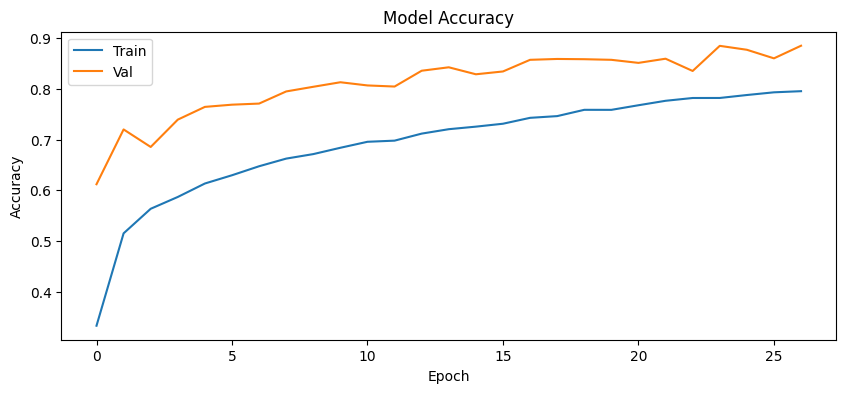

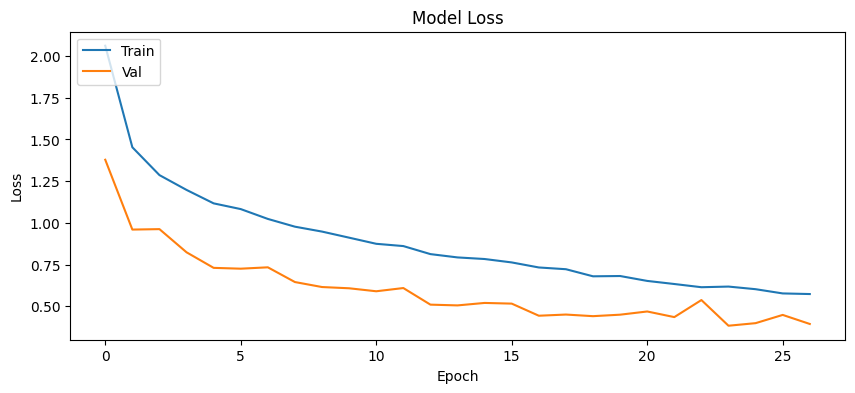

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

##Model Testing and Prediction

In [46]:
from google.colab import files
uploaded = files.upload()

Saving tlb.jpg to tlb (1).jpg


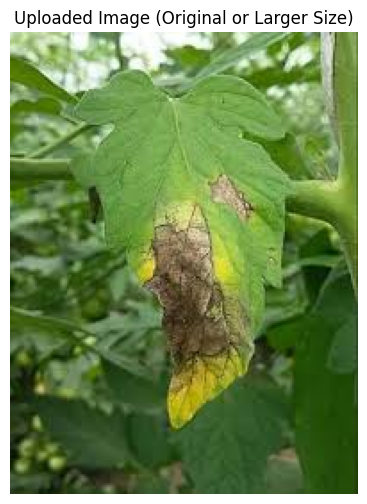

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class =  Tomato_Late_blight


In [47]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

TARGET_SIZE = (48, 48)

image_path = list(uploaded.keys())[0]

img_display = load_img(image_path)

plt.figure(figsize=(6, 6))
plt.imshow(img_display)
plt.axis('off')
plt.title('Uploaded Image (Original or Larger Size)')
plt.show()

img_model = load_img(image_path, target_size=TARGET_SIZE, color_mode='rgb')


img_array = img_to_array(img_model)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

pred = model.predict(img_array)
pred_class_index = np.argmax(pred)

if 'train_data' in globals() and hasattr(train_data, 'class_indices'):
    pred_class_label = list(train_data.class_indices.keys())[pred_class_index]
    print("Predicted class = ", pred_class_label)
else:
    print("Could not determine class labels. 'train_data' variable or its 'class_indices' attribute not found.")

In [43]:
from google.colab import files
uploaded = files.upload()

Saving pbb1.jpg to pbb1.jpg


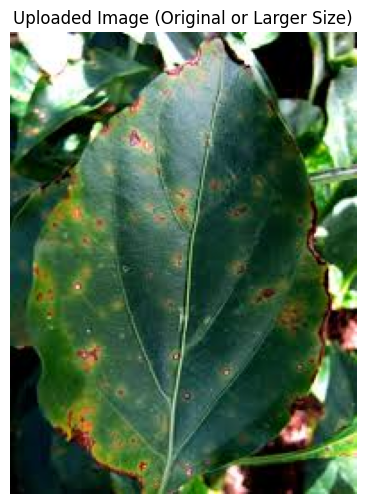

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class =  Pepper__bell___Bacterial_spot


In [44]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

TARGET_SIZE = (48, 48)

image_path = list(uploaded.keys())[0]

img_display = load_img(image_path)

plt.figure(figsize=(6, 6))
plt.imshow(img_display)
plt.axis('off')
plt.title('Uploaded Image (Original or Larger Size)')
plt.show()

img_model = load_img(image_path, target_size=TARGET_SIZE, color_mode='rgb')


img_array = img_to_array(img_model)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

pred = model.predict(img_array)
pred_class_index = np.argmax(pred)

if 'train_data' in globals() and hasattr(train_data, 'class_indices'):
    pred_class_label = list(train_data.class_indices.keys())[pred_class_index]
    print("Predicted class = ", pred_class_label)
else:
    print("Could not determine class labels. 'train_data' variable or its 'class_indices' attribute not found.")